# Introducción

Proyecto para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. __El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad__.

Se realizará un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. __Se contará con los datos de 500 clientes de Megaline__: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. __Se analizará el comportamiento de los clientes y determinará qué tarifa de prepago genera más ingresos__.

# Descripción de las tarifas

__Megaline redondea los segundos a minutos y los megabytes a gigabytes. Para llamadas, cada llamada individual se redondea: incluso si la llamada duró solo un segundo, se contará como un minuto. Para tráfico web, las sesiones web individuales no se redondean. En vez de esto, el total del mes se redondea hacia arriba. Si alguien usa 1025 megabytes este mes, se le cobrarán 2 gigabytes__.

A continuación puedes ver una descripción de las tarifas:

__Surf__

- Pago mensual: 20 dólares.
- 500 minutos al mes, 50 SMS y 15 GB de datos.
Si se exceden los límites del paquete:
- 1 minuto: 3 centavos.
- 1 SMS: 3 centavos.
- 1 GB de datos: 10 dólares.

__Ultimate__

- Pago mensual: 70 dólares.
- 3000 minutos al mes, 1000 SMS y 30 GB de datos.
Si se exceden los límites del paquete:
- 1 minuto: 1 centavo.
- 1 SMS: 1 centavo.
- 1 GB de datos: 7 dólares.

# Diccionario de datos

En este proyecto, se trabajará con cinco tablas diferentes.

La tabla `users` (datos sobre los usuarios):
 
- `user_id`: identificador único del usuario.
- `first_name`: nombre del usuario.
- `last_name`: apellido del usuario.
- `age`: edad del usuario (en años).
- `reg_date`: fecha de suscripción (dd, mm, aa).
- `churn_date`: la fecha en la que el usuario dejó de usar el servicio (si el valor es ausente, la tarifa se estaba usando cuando fue extraída esta base de datos).
- `city`: ciudad de residencia del usuario.
- `plan`: nombre de la tarifa.

La tabla `calls` (datos sobre las llamadas):
 
- `id`: identificador único de la llamada.
- `call_date`: fecha de la llamada.
- `duration`: duración de la llamada (en minutos).
- `user_id`: el identificador del usuario que realiza la llamada.

La tabla `messages` (datos sobre los SMS):
 
- `id`: identificador único del SMS.
- `message_date`: fecha del SMS.
- `user_id`: el identificador del usuario que manda el SMS.

La tabla `internet` (datos sobre las sesiones web):
 
- `id`: identificador único de la sesión.
- `mb_used`: el volumen de datos gastados durante la sesión (en megabytes).
- `session_date`: fecha de la sesión web.
- `user_id`: identificador del usuario.

La tabla `plans` (datos sobre las tarifas):
 
- `plan_name`: nombre de la tarifa.
- `usd_monthly_fee`: pago mensual en dólares estadounidenses.
- `minutes_included`: minutos incluidos al mes.
- `messages_included`: SMS incluidos al mes.
- `mb_per_month_included`: datos incluidos al mes (en megabytes).
- `usd_per_minute`: precio por minuto tras exceder los límites del paquete (por ejemplo, si el paquete incluye 100 minutos, - el operador cobrará el minuto 101).
- `usd_per_message`: precio por SMS tras exceder los límites del paquete.
- `usd_per_gb`: precio por gigabyte de los datos extra tras exceder los límites del paquete (1 GB = 1024 megabytes).

## Inicialización

Para inicializar el proyecto se cargan todas las librerías necesarias y se le da una estética uniforme y agradable a los gráficos del documento.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st 
import seaborn as sns
import math as mt # Cargar todas las librerías

Las librerías fueron correctamente importadas, ahora estilizamos los gráficos.

In [2]:
plt.style.use('ggplot') #Dar estética a los gráficos

Ahora podemos pasar a la carga de datos.

### Cargar datos

Se procederá a importar los datasets necesarios para el desarrollo del informe

In [3]:
calls = pd.read_csv('/datasets/megaline_calls.csv') # Cargar los archivos de datos en diferentes DataFrames
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')

Los datos son montados correctamente, pasamos a la fase de preparación.

## Preparar los datos

Los datos serán limpiados, corregidos y enriquecidos según corresponda.

### Tarifas

Se le dará una revisión al dataset buscando valores ausentes, duplicados y enriqueciendo información según corresponda.

In [4]:
plans.info() # Imprimir la información general/resumida sobre el DataFrame de las tarifas
plans # Imprimir una muestra de los datos para las tarifas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Se observan todas las características de los planes a estudiar, la información se entiende claramente y el tipo de datos es correcto, no necesita cambios por ahora. Para el análisis posterior, se deberá hacer una conversión de megabytes a gigabytes.

### Usuarios/as

Se le dará una revisión al dataset buscando valores ausentes, duplicados y enriqueciendo información según corresponda.

In [5]:
users.info() # Imprimir la información general/resumida sobre el DataFrame de usuarios
users.head() # Imprimir una muestra de datos para usuarios

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


Se observa que las columnas de fecha (`churn_date` y `reg_date`) están en formato erróneo, por lo cual serán corregidas, los valores de la columna `city` están en mayúsculas y minúsculas por lo que se comprobará la existencia de duplicados implícitos y de ser encontrados serán trabajados.

Se observan, también, valores ausentes en la columna `churn_date` los cuales indican que el usuario en cuestión no se ha dado de baja del plan al momento en que se recopiló esta información.

Ahora se buscarán filas completamente duplicadas y duplicados implícitos en el dataset.

In [6]:
print(users.duplicated().sum())
print()
print(len(users['city'].value_counts()))
print(len(users['city'].str.lower().value_counts()))

0

73
73


No se encuentran duplicados explícitos ni implícitos.

In [7]:
users['reg_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
print(users['reg_date'].dtype)

datetime64[ns]


Se corrige y formatea la columna `reg_date` (fecha de registro).

### Llamadas

Se le dará una revisión al dataset buscando valores ausentes, duplicados y enriqueciendo información según corresponda.

In [8]:
calls.info() # Imprimir la información general/resumida sobre el DataFrame de las llamadas
calls.head() # Imprimir una muestra de datos para las llamadas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


Se observa (al igual que en el DataFrame anterior) que la columna que informa la fecha de la llamada está en un formato erróneo.

In [9]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
print(calls['call_date'].dtype)

datetime64[ns]


Se corrige el tipo de datos de la columna `call_date`.

Se procederá a buscar valores iguales a cero, para ver si el dataset contabiliza llamadas cortadas o desviadas.

In [10]:
print(len(calls[calls['duration'] == 0]))
print(len(calls))
percent = calls[calls['duration'] == 0]
print('El porcentaje de datos perdidos es de:', format((len(percent) / len(calls)), '.1%'))

26834
137735
El porcentaje de datos perdidos es de: 19.5%


__Se descubre un gran porcentaje de llamadas con duración 0, que serán eliminadas del dataset ya que no generan cobros__ y solo obstaculizarán el futuro análisis.

In [11]:
calls = calls[calls['duration'] != 0]

Una vez eliminadas, se redondearán los minutos hacia arriba para cumplir con las reglas de tarifa de la compañía.

In [12]:
def rminutes(row):
    
    duration = row['duration']
    return mt.ceil(duration)
        
calls['duration'] = calls.apply(rminutes, axis=1)
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9
1,1000_145,1000,2018-12-27,14
2,1000_247,1000,2018-12-27,15
3,1000_309,1000,2018-12-28,6
4,1000_380,1000,2018-12-30,5


Se redondea la duración de las llamadas hacia arriba para seguir los lineamientos de la compañía.

### Mensajes

Se le dará una revisión al dataset buscando valores ausentes, duplicados y enriqueciendo información según corresponda.

In [13]:
messages.info() # Imprimir la información general/resumida sobre el DataFrame de los mensajes
messages.head() # Imprimir una muestra de datos para los mensajes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


Se observa (al igual que en el DataFrame anterior) que la columna que informa la fecha de la llamada está en un formato erróneo.

In [14]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
print(messages['message_date'].dtype)

datetime64[ns]


Se corrige el tipo de datos de la columna `message_date`.

### Internet

Se le dará una revisión al dataset buscando valores ausentes, duplicados y enriqueciendo información según corresponda

In [45]:
internet.info() # Imprimir la información general/resumida sobre el DataFrame de internet
internet.head() # Imprimir una muestra de datos para el tráfico de internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Se observa (al igual que en el DataFrame anterior) que la columna que informa la fecha de la llamada está en un formato erróneo.

In [17]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
print(internet['session_date'].dtype)

datetime64[ns]


Se corrige el tipo de datos de la columna `session_date`. __Cuando se agrupen los datos para el análisis se tendrá que redondear hacia arriba lo valores de la transformación de mbegabyte a gigabyte__, debido a que es un redondeo mensual no se puede hacer en el preanálisis.

## Agregar datos por usuario


Se comienza la construcción de un dataset con los datos del consumo mensual de internet, llamadas y mensajes de cada cliente, para poder calcular con exactitud cuanto aporta cada uno a la compañía

In [18]:
user_calls = calls.merge(users,on='user_id') # Cálculo el número de llamadas hechas por cada usuario al mes.
user_calls['month'] = user_calls['call_date'].dt.month
user_calls_m = user_calls.groupby(['user_id','month'])['id'].count()

user_calls_m.head()

user_id  month
1000     12       16
1001     8        22
         9        38
         10       47
         11       49
Name: id, dtype: int64

Mediante un `.merge()` sumamos al dataset de las llamadas, la información de los usuarios, se crea la columna `month` a partir de la columna `call_date` y finalmente se agrupa `user_calls` por id de usuario y mes, realizando un conteo de las llamadas por usuario al mes. 

El mismo procedimiento se repetirá para minutos, megabytes y mensajes, solo que aplicando `.sum()` en el caso de los minutos y los megabytes. Comenzamos con los minutos.

In [19]:
user_minutes_m = user_calls.groupby(['user_id','month'])['duration'].sum() # Cálculo la cantidad de minutos usados por cada usuario al mes. 

Seguimos con los mensajes.

In [20]:
user_messages_m = messages.merge(users, on='user_id') # Cálculo el número de mensajes enviados por cada usuario al mes.
user_messages_m['month'] = user_messages_m['message_date'].dt.month
user_messages_m = user_messages_m.groupby(['user_id','month'])['id'].count()

Finalizamos con el consumo de internet.

In [21]:
user_internet_m = internet.merge(users,on='user_id') # Cálcula el volumen del tráfico de Internet usado por cada usuario al mes.
user_internet_m['month'] = user_internet_m['session_date'].dt.month
user_internet_m = user_internet_m.groupby(['user_id','month'])['mb_used'].sum()

Ya están todas las variables agrupadas por usuario y por mes, solo queda juntarlas en un único dataset.

In [22]:
df_concat = pd.concat([user_calls_m, user_minutes_m, user_internet_m,user_messages_m], axis='columns') # Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
df_concat = df_concat.set_axis(['calls_num','minutes_incall','mb_used','message_num'],axis=1)
df_concat = df_concat.reset_index('month')

df_concat.head()

,month,calls_num,minutes_incall,mb_used,message_num
user_id,,,,,
1000,12,16.0,124.0,1901.47,11.0
1001,8,22.0,182.0,6919.15,30.0
1001,9,38.0,315.0,13314.82,44.0
1001,10,47.0,393.0,22330.49,53.0
1001,11,49.0,426.0,18504.30,36.0


Mediante `concat` agrupamos el __número de llamadas, minutos hablados, megabytes usados, y mensajes enviados, por usuario y por mes__. 

Ahora si podemos hacer la transformación de megabytes a gigabytes.

In [23]:
print(df_concat['mb_used'].isna().sum()) #Búsqueda de duplicados
df_concat['mb_used'] = df_concat['mb_used'].fillna(0) #Corrección de duplicados
print(df_concat['mb_used'].isna().sum())
df_concat['gb'] = df_concat['mb_used'] / 1024 #Creación de la columna 'gb'

def rinternet(row): #Mediante esta función se redondea hacia arriba el número de gigabytes mensuales
    
    gb = row['gb']
    return mt.ceil(gb)
        
df_concat['gb_used'] = df_concat.apply(rinternet, axis=1)
df_concat = df_concat.drop(columns=['mb_used','gb']) #Se eliminan las columnas sobrantes
df_concat = df_concat.reset_index()

df_concat.head()

16
0


,user_id,month,calls_num,minutes_incall,message_num,gb_used
0,1000,12,16.0,124.0,11.0,2
1,1001,8,22.0,182.0,30.0,7
2,1001,9,38.0,315.0,44.0,14
3,1001,10,47.0,393.0,53.0,22
4,1001,11,49.0,426.0,36.0,19


El `concat` genera valores ausentes, ya que hay clientes que en algunos meses no usaron internet, pero si, otros servicios, por lo que antes de poder redondear es necesario procesar estos valores ausentes, reemplazandolos con 0.

Posteriormente, mediante una función, __se redondea hacia arriba el número de gigabytes usados__, quedando una columna de valores enteros y calzando con las políticas de cobro de la compañía.

Ahora queda agregar los datos específicos de cada plan para poder hacer los cálculos de ingreso por cliente.

In [24]:
user_plan = df_concat.merge(users,on='user_id') # Añade la información de la tarifa
user_plan = user_plan.drop(['first_name', 'last_name', 'age', 'city', 'reg_date', 'churn_date'],axis=1) #Eliminar info residual
user_plan = user_plan.set_axis(['user_id', 'month', 'calls_num', 'minutes_incall', 'message_num', 'gb_used', 'plan_name'],axis=1)

user_plan = user_plan.merge(plans, on='plan_name') #Se agrega la info detallada de cada plan

user_plan['message_num'].fillna(0, inplace=True) # Se reemplazan con 0 los valores ausentes generados en el concat anterior
user_plan['calls_num'].fillna(0, inplace=True)
user_plan['minutes_incall'].fillna(0, inplace=True)

user_plan.head()

,user_id,month,calls_num,minutes_incall,message_num,gb_used,plan_name,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,12,16.0,124.0,11.0,2,ultimate,1000,30720,3000,70,7,0.01,0.01
1,1006,11,2.0,10.0,15.0,3,ultimate,1000,30720,3000,70,7,0.01,0.01
2,1006,12,7.0,59.0,139.0,32,ultimate,1000,30720,3000,70,7,0.01,0.01
3,1008,10,54.0,476.0,21.0,17,ultimate,1000,30720,3000,70,7,0.01,0.01
4,1008,11,50.0,446.0,37.0,24,ultimate,1000,30720,3000,70,7,0.01,0.01


Se realiza un `merge` de `df_concat` con el dataset de usuarios, para saber qué plan usa cada uno, luego (mediante otro `merge`) se agrega la información completa del plan al dataset, quedando este __listo para calcular los pagos mensuales de los clientes__.

### Cálculo de ingresos

Se generarán los cálculos para insertar al dataset el aporte mensual de cada cliente, considerando su aporte base y cobros extra por cualquier servicio.

In [25]:
def minutes(row): #Función para calcular el cobro de minutos
    
    plan_name = row['plan_name']
    minutes_incall = row['minutes_incall']
    
    if plan_name == 'surf':
        if minutes_incall > 500:
            return (minutes_incall-500)*0.03
        else:
            return 0
    if plan_name == 'ultimate':
        if minutes_incall > 3000:
            return (minutes_incall-3000)*0.01
        else:
            return 0
        
user_plan['extra_usd_min'] = user_plan.apply(minutes, axis=1)

def gb(row): #Función para calcular el cobro de uso de gigabytes mensual
    
    plan_name = row['plan_name']
    gb_used = row['gb_used']
    
    if plan_name == 'surf':
        if gb_used > 15:
            return (gb_used-15)*10
        else:
            return 0
    if plan_name == 'ultimate':
        if gb_used > 30:
            return (gb_used-30)*7
        else:
            return 0
        
user_plan['extra_usd_gb'] = user_plan.apply(gb, axis=1)

def messages(row): #Función para calcular el cobro por envío de mensajes
    
    plan_name = row['plan_name']
    message_num = row['message_num']
    
    if plan_name == 'surf':
        if message_num > 50:
            return (message_num-50)*0.03
        else:
            return 0
    if plan_name == 'ultimate':
        if message_num > 1000:
            return (message_num-1000)*0.01
        else:
            return 0
        
user_plan['extra_usd_message'] = user_plan.apply(messages, axis=1)
user_plan['total_income'] = user_plan['usd_monthly_pay'] + user_plan['extra_usd_min'] + user_plan['extra_usd_gb'] + user_plan['extra_usd_message']
user_plan.head()

,user_id,month,calls_num,minutes_incall,message_num,gb_used,plan_name,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,extra_usd_min,extra_usd_gb,extra_usd_message,total_income
0,1000,12,16.0,124.0,11.0,2,ultimate,1000,30720,3000,70,7,0.01,0.01,0.0,0,0.0,70.0
1,1006,11,2.0,10.0,15.0,3,ultimate,1000,30720,3000,70,7,0.01,0.01,0.0,0,0.0,70.0
2,1006,12,7.0,59.0,139.0,32,ultimate,1000,30720,3000,70,7,0.01,0.01,0.0,14,0.0,84.0
3,1008,10,54.0,476.0,21.0,17,ultimate,1000,30720,3000,70,7,0.01,0.01,0.0,0,0.0,70.0
4,1008,11,50.0,446.0,37.0,24,ultimate,1000,30720,3000,70,7,0.01,0.01,0.0,0,0.0,70.0


Mediante funciones se calcula automáticamente el cobro para uso de llamadas, mensajes e internet, con las condiciones específicas proporcionadas por la compañía (se encuentran al inicio del documento). Mediantes estos calculos __obtenemos un dataset con los montos específicos generados mensualmente por cada cliente, y además, con columnas específicas para cobros extra__.

## Estudio del comportamiento de usuario

Mediante estadística descriptiva y gráficos se estudiará el comportamiento y los ingresos de los usuarios de ambos planes

### Análisis de llamadas

Se realizará un análisis de las llamadas por mes y también sobre los valores totales usando estadística descriptiva y diversos gráficos de apoyo

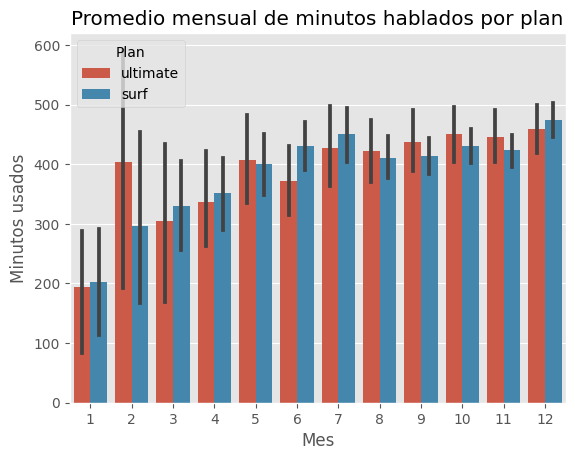

In [26]:
sns.barplot(x='month', y='minutes_incall', data=user_plan, hue='plan_name').set_title('Promedio mensual de minutos hablados por plan')
plt.ylabel('Minutos usados')
plt.xlabel('Mes')
plt.legend(title='Plan');

Sólo se observa una diferencia notoria en el mes de febrero, donde los usuarios del plan ultimate hablaron, en promedio al mes, más de 100 minutos, que los usuarios del plan surf.

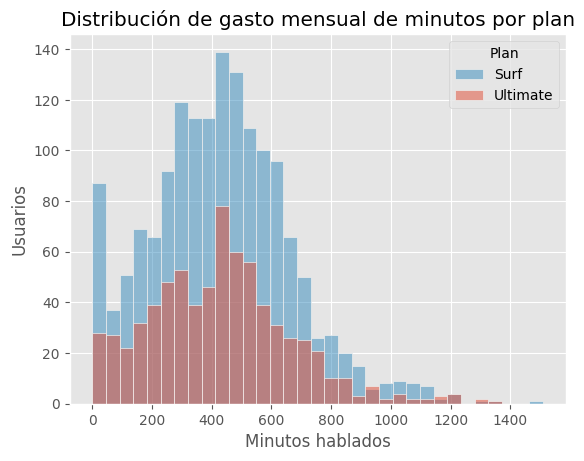

In [27]:
sns.histplot(x='minutes_incall', hue='plan_name', data=user_plan).set_title('Distribución de gasto mensual de minutos por plan')
plt.ylabel('Usuarios')
plt.xlabel('Minutos hablados')
plt.legend(title='Plan', labels=['Surf', 'Ultimate']);

__Se observan comportamientos similares en cuanto a la duración de las llamadas a pesar de las diferencias en las tarifas de cada plan__, se seguirá investigando

In [28]:
print('Plan surf:')
print(user_plan[user_plan['plan_name'] == 'surf']['minutes_incall'].describe()) # Calcula la media y la varianza de la duración mensual de llamadas.
print()
print('Plan ultimate:')
print(user_plan[user_plan['plan_name'] == 'ultimate']['minutes_incall'].describe())

Plan surf:
count    1573.000000
mean      428.749523
std       234.453150
min         0.000000
25%       272.000000
50%       425.000000
75%       576.000000
max      1510.000000
Name: minutes_incall, dtype: float64

Plan ultimate:
count     720.000000
mean      430.450000
std       240.508762
min         0.000000
25%       260.000000
50%       424.000000
75%       565.250000
max      1369.000000
Name: minutes_incall, dtype: float64


Queda al descubierto que (al menos en esta muestra) __los usuarios del plan ultimate, están muy lejos de usar los 3.000 minutos mensuales de su plan (430 en promedio__, con un máximo de 1292), mientras que __los usuarios del plan surf en promedio usan 428 minutos de 500 disponibles__, y que en aproximadamente 1/4 de los registros, las llamadas mensuales de este plan sobrepasaron el límite de 500 minutos mensuales.

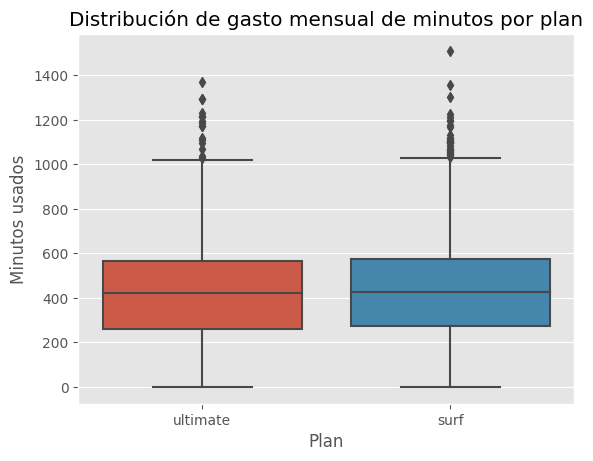

In [29]:
sns.boxplot(y='minutes_incall', x='plan_name', data=user_plan).set_title('Distribución de gasto mensual de minutos por plan')
plt.ylabel('Minutos usados')
plt.xlabel('Plan');

En cuanto a la duración mensual de las llamadas, se puede apreciar que __existen muy pocas diferencias en cuanto al plan surf y al plan ultimate__, ya que, los minutos promedio por mes y la varianza de estos son prácticamente iguales en ambos planes (a pesar de sus notorias diferencias en cuanto a capacidades y precio). 

### Análisis de mensajes

Se realizará un análisis de los mensajes enviados por mes y también sobre los valores totales usando estadística descriptiva y gráficos de apoyo.

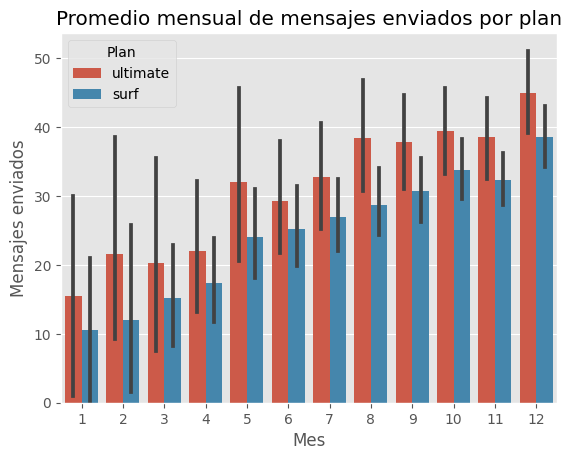

In [30]:
sns.barplot(x='month', y='message_num', data=user_plan, hue='plan_name').set_title('Promedio mensual de mensajes enviados por plan')
plt.ylabel('Mensajes enviados')
plt.xlabel('Mes')
plt.legend(title='Plan');

En cuanto a los mensajes, se puede apreciar que en general, __los usuarios del plan ultimate envían más mensajes al mes que los del plan surf__, esta diferencia se observa pronunciadamente en los meses de febreri, mayo y agosto.

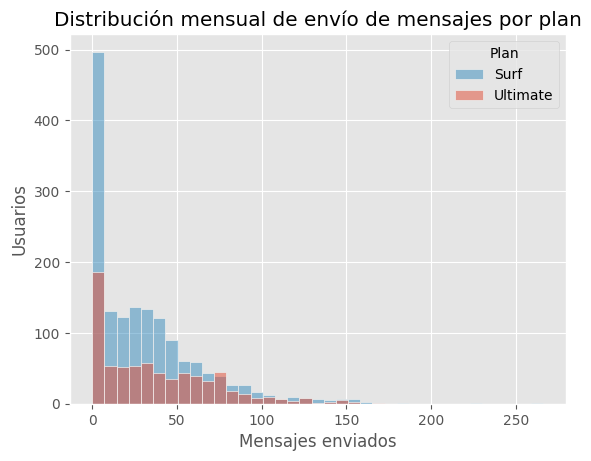

In [31]:
sns.histplot(x='message_num', hue='plan_name', data=user_plan).set_title('Distribución mensual de envío de mensajes por plan')
plt.ylabel('Usuarios')
plt.xlabel('Mensajes enviados')
plt.legend(title='Plan', labels=['Surf', 'Ultimate']);

En cuanto a la distribución, podemos apreciar en el histograma que, en el plan surf, la cantidad de mensajes mensuales enviados cae drásticamente después del límite mensual de 50, mientras que en el plan ultimate, la pendiente es más suave.

In [32]:
print('Plan surf:')
print(user_plan[user_plan['plan_name'] == 'surf']['message_num'].describe()) 
print()
print('Plan ultimate:')
print(user_plan[user_plan['plan_name'] == 'ultimate']['message_num'].describe())

Plan surf:
count    1573.000000
mean       31.159568
std        33.566717
min         0.000000
25%         3.000000
50%        24.000000
75%        47.000000
max       266.000000
Name: message_num, dtype: float64

Plan ultimate:
count    720.000000
mean      37.551389
std       34.767179
min        0.000000
25%        7.000000
50%       30.000000
75%       61.000000
max      166.000000
Name: message_num, dtype: float64


Al igual que con los minutos, en el plan surf, aproximadamente 1/4 de los registros mensuales de mensajes sobrepasa el límite de 50, mientras que el plan ultimate, el límite de 1.000 está lejos de ser alcanzado.

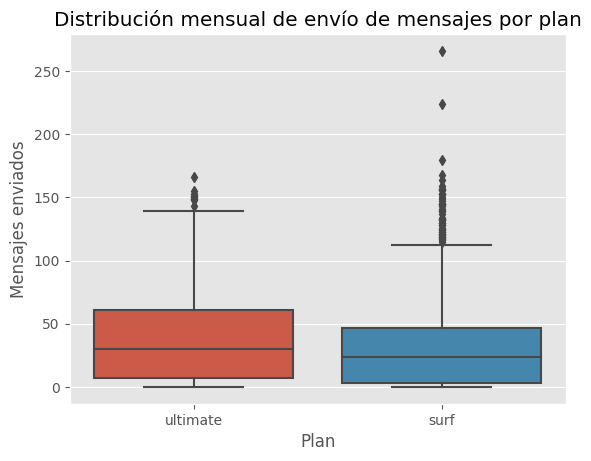

In [33]:
sns.boxplot(y='message_num', x='plan_name', data=user_plan).set_title('Distribución mensual de envío de mensajes por plan')
plt.ylabel('Mensajes enviados')
plt.xlabel('Plan');

Este gráfico también indica: que los usuarios del plan ultimate envían más mensajes y que hay más valores atípicos en el plan surf, como se proponía en el método descriptivo anterior.

### Análisis de consumo de internet

Se realizará un análisis del consumo de internet en gigabytes por mes y también sobre los valores totales usando estadística descriptiva y diversos gráficos de apoyo.

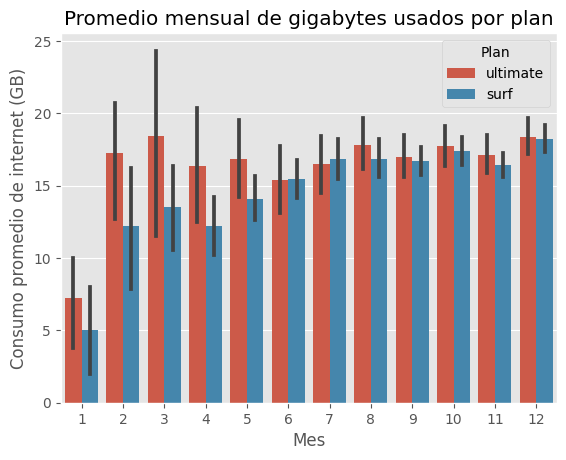

In [34]:
sns.barplot(x='month', y='gb_used', data=user_plan, hue='plan_name').set_title('Promedio mensual de gigabytes usados por plan')
plt.ylabel('Consumo promedio de internet (GB)')
plt.xlabel('Mes')
plt.legend(title='Plan');

Al analizar el detalle mensual, podemos obsevar que __en los meses de febrero, marzo y abril, los datos usados en promedio en el plan ultimate superan por más de 2GB a los usados en el plan surf__.

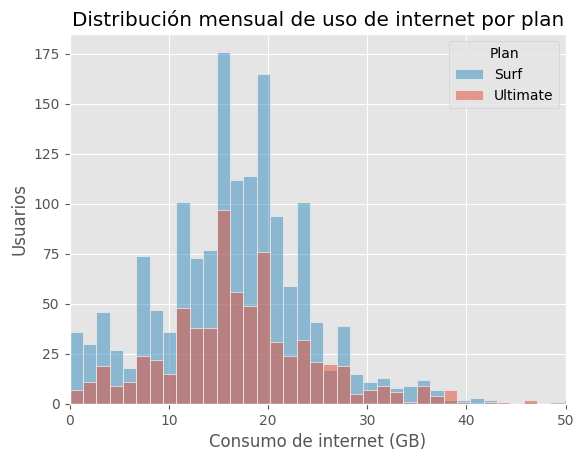

In [35]:
sns.histplot(x='gb_used', hue='plan_name', data=user_plan).set_title('Distribución mensual de uso de internet por plan')
plt.ylabel('Usuarios')
plt.xlabel('Consumo de internet (GB)')
plt.xlim(0, 50)
plt.legend(title='Plan', labels=['Surf', 'Ultimate']);

__La distribución mensual de consumo de internet es bastante similar para los dos planes, a pesar de que los usarios del plan surf sufren de cobros adicionales al sobrepasar los 15 gigabytes mensuales en consumo__.

In [36]:
print('Plan surf:')
print(user_plan[user_plan['plan_name'] == 'surf']['gb_used'].describe()) 
print()
print('Plan ultimate:')
print(user_plan[user_plan['plan_name'] == 'ultimate']['gb_used'].describe())

Plan surf:
count    1573.000000
mean       16.670693
std         7.847522
min         0.000000
25%        12.000000
50%        17.000000
75%        21.000000
max        70.000000
Name: gb_used, dtype: float64

Plan ultimate:
count    720.000000
mean      17.306944
std        7.670108
min        0.000000
25%       13.000000
50%       17.000000
75%       21.000000
max       46.000000
Name: gb_used, dtype: float64


__Hay poca diferencia entre el promedio y la media del consumo de internet entre los planes__.

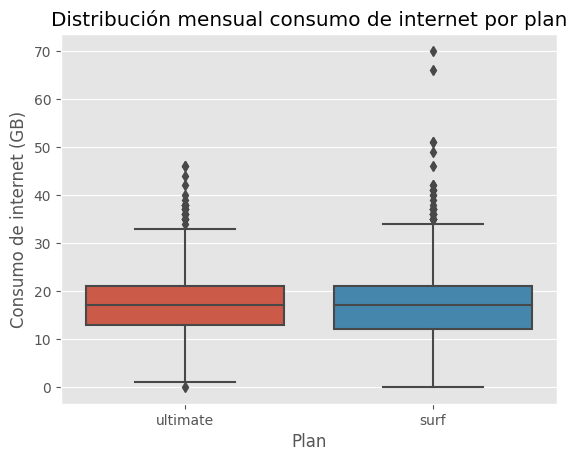

In [37]:
sns.boxplot(y='gb_used', x='plan_name', data=user_plan).set_title('Distribución mensual consumo de internet por plan')
plt.ylabel('Consumo de internet (GB)')
plt.xlabel('Plan');

Observando los gráficos de caja podemos apreciar que más de la mitad de los registros mensuales analizados, en el plan surf, sobrepasan el límite mensual de 15 GB, mientras que en el plan ultimate es un porcentaje muy bajo el que sobreṕasa el límite de 30 GB.

### Análisis de ingresos mensuales por cliente

Se realizará un análisis de los ingresos mensuales por cliente y también sobre los valores totales usando estadística descriptiva y diversos gráficos.

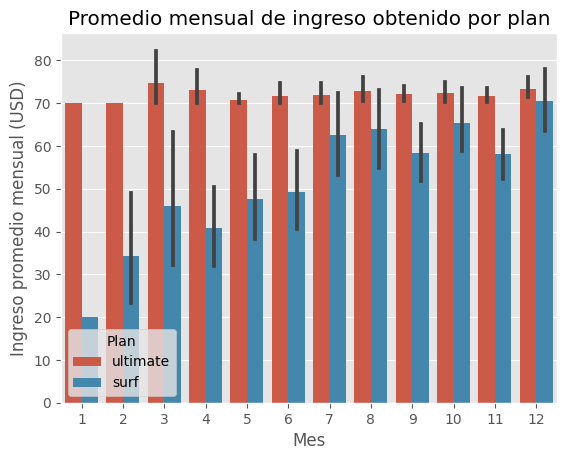

In [38]:
sns.barplot(x='month', y='total_income', data=user_plan, hue='plan_name').set_title('Promedio mensual de ingreso obtenido por plan')
plt.ylabel('Ingreso promedio mensual (USD)')
plt.xlabel('Mes')
plt.legend(title='Plan');

__El ingreso promedio mensual del plan ultimate es notablemente superior al del plan surf__, estando parejos sólo el mes de diciembre, y marcando la mayor diferencia el mes de enero.

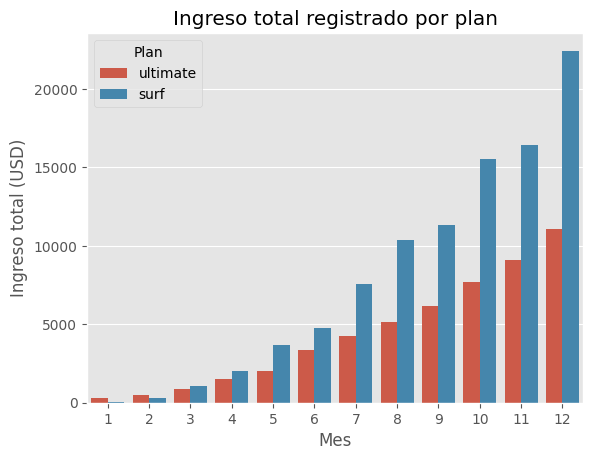

In [39]:
sns.barplot(x='month', y='total_income', data=user_plan, hue='plan_name', estimator=sum, ci=None).set_title('Ingreso total registrado por plan')
plt.ylabel('Ingreso total (USD)')
plt.xlabel('Mes')
plt.legend(title='Plan');

Cabe destacar que si bien el ingreso promedio de un usario del plan ultimate es mayor al de uno del plan surf, si la proporción de clientes del plan surf es considerablemente mayor a la del ultimate, el primero podría generar mas ingresos totales que el segundo, como se observa en este gráfico.

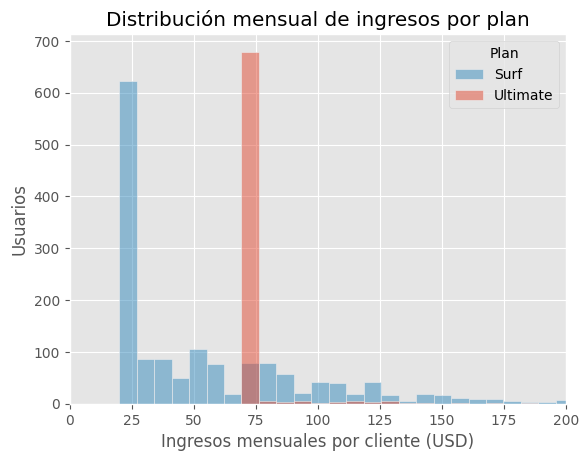

In [40]:
sns.histplot(x='total_income', hue='plan_name', data=user_plan).set_title('Distribución mensual de ingresos por plan')
plt.ylabel('Usuarios')
plt.xlabel('Ingresos mensuales por cliente (USD)')
plt.xlim(0, 200)
plt.legend(title='Plan', labels=['Surf', 'Ultimate']);

Se observa que los clientes del plan ultimate generalmente no caen en cobros adicionales, no así los clientes del plan surf.

In [41]:
print('Plan surf:')
print(user_plan[user_plan['plan_name'] == 'surf']['total_income'].describe()) 
print()
print('Plan ultimate:')
print(user_plan[user_plan['plan_name'] == 'ultimate']['total_income'].describe())

Plan surf:
count    1573.000000
mean       60.706408
std        55.388042
min        20.000000
25%        20.000000
50%        40.360000
75%        80.360000
max       590.370000
Name: total_income, dtype: float64

Plan ultimate:
count    720.000000
mean      72.313889
std       11.395108
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      182.000000
Name: total_income, dtype: float64


En base a la muestra analizada, se puede observar que en promedio, __un usuario del plan últimate genera 12 dolares más en ingresos a la compañía que uno del plan surf__. Podemos observar también que los usuarios del plan ultimate rara vez generan ingresos extra a la mensualidad fija del plan, en comparación con __los usuarios del plan surf, que sobrepasan frecuentemente los límites de su plan (mas del 50% de los registros)__, generando ingresos extra considerables. Segun los datos observados, esto se debe a que los usuarios de la compañía usan los servicios de forma muy parecida independiente del plan que hayan contratado.

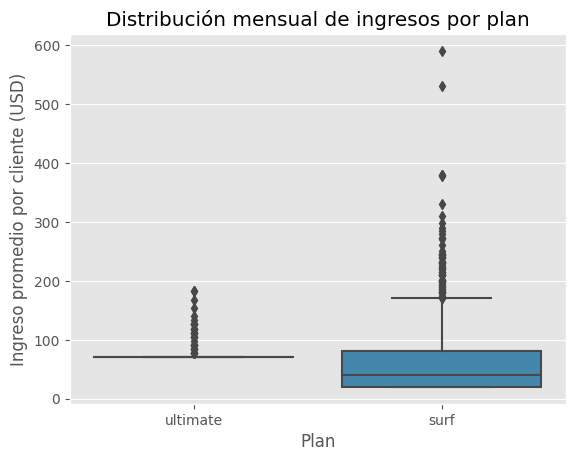

In [42]:
sns.boxplot(y='total_income', x='plan_name', data=user_plan).set_title('Distribución mensual de ingresos por plan')
plt.ylabel('Ingreso promedio por cliente (USD)')
plt.xlabel('Plan');

Los cuartiles son imperceptibles en el plan ultimate, lo que da cuenta de que una tremenda mayoría no paga cargos adicionales, en cambio en el plan surf un 25% de los usuarios paga más de 70 dólares al mes (siendo que el precio base del plan es de 15 dólares).

## Prueba de hipótesis estadísticas

Finalizando este proyecto se testearán estadísticamente dos hipótesis muy importantes para el desarrollo del proyecto, __se usará la prueba no paramétrica de Mann-Whitney__ debido que las hipótesis tendrán relación con los ingresos y hemos observado que estos poseen distribuciones anormales y varianzas muy diferentes:

### Hipótesis 1

Se probará la siguiente hipótesis: __Son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf__.

La hipótesis nula es que los ingresos promedio no varían según el plan contratado, si se rechaza, quiere decir que hay una variación estadísticamente considerable entre los ingresos promedio del plan ultimate y el plan surf.
Se usará una prueba estadística para comparar las medias de dos muestras de datos con varianzas diferentes.

In [43]:
print('Plan Surf')
print(user_plan[user_plan['plan_name'] == 'surf']['total_income'].describe())
print()
print('Plan Ultimate')
print(user_plan[user_plan['plan_name'] == 'ultimate']['total_income'].describe())
print()

alpha = 0.05
results = st.mannwhitneyu(user_plan[user_plan['plan_name'] == 'surf']['total_income'],
                       user_plan[user_plan['plan_name'] == 'ultimate']['total_income']) # Prueba las hipótesis
print('valor p:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

Plan Surf
count    1573.000000
mean       60.706408
std        55.388042
min        20.000000
25%        20.000000
50%        40.360000
75%        80.360000
max       590.370000
Name: total_income, dtype: float64

Plan Ultimate
count    720.000000
mean      72.313889
std       11.395108
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      182.000000
Name: total_income, dtype: float64

valor p: 1.912179587173433e-48
Rechazamos la hipótesis nula


Se comprueba estadísticamente que __el ingreso promedio de el plan ultimate es mayor que el del plan surf__.

### Hipótesis 2

Se probará la siguiente hipótesis: __El ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones__.

La hipótesis nula es que los ingresos promedio no varían según las ubicaciones seleccionadas, si se rechaza, quiere decir que hay una variación estadísticamente considerable entre los ingresos promedio en las localizaciones analizadas.
Se usará una prueba estadística para comparar las medias de dos muestras de datos con varianzas iguales.

In [44]:
hipo = user_plan.merge(users, on='user_id') # Prueba las hipótesis
hipony = hipo[hipo['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_income']
print('NY-NJ')
print(hipony.describe())
print()
hipo_rest = hipo[hipo['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_income']
print('El resto de las regiones')
print(hipo_rest.describe())
print()
alpha = 0.05
results = st.mannwhitneyu(hipony,hipo_rest) # Prueba las hipótesis
print('valor p:', results.pvalue)
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

NY-NJ
count    377.000000
mean      59.921353
std       43.537865
min       20.000000
25%       20.000000
50%       51.770000
75%       72.460000
max      280.000000
Name: total_income, dtype: float64

El resto de las regiones
count    1916.000000
mean       65.222771
std        47.170414
min        20.000000
25%        24.927500
50%        70.000000
75%        70.000000
max       590.370000
Name: total_income, dtype: float64

valor p: 0.003927631468615441
Rechazamos la hipótesis nula


Se comprueba estdísticamente que __hay diferencia entre el ingreso promedio del área `NY-NJ` con el del resto de las áreas, siendo el primero menor que el segundo__.

## Conclusión general

En este apartado se desarollarán ampliamente todas las conclusiones obtenidas en el desarrollo del informe, haciendo hincapié en los aspectos fundamentales fundamentales del trabajo, como lo son: el resumen de los hallazgos clave, la etapa de preprocesamiento, relevancia de los hallazgos, sugerencias y las reflexiones finales sobre el desarrollo de esta tarea.

### Resumen de hallazgos clave

Los principales hallazgos encontrados en el análisis exploratorio y las pruebas estadísticas son:
- __Los comportamiento de usuario son parecidos, independiente del plan contratado y de si se generan o no cobros adicionales por uso sobre el límite__ (solo los mensajes son un poco influenciados por el límite mensual), __siendo los usuarios del plan surf quienes muy frecuentemente exceden el límite de consumo mensual__ (más del 50% de los registros de ingreso mensual superan los 20 dolares mensuales) en comparación con los del plan ultimate que rara vez lo hacen (solo valores atípicos).
- Viendolo al detalle, en cuanto a llamadas y consumos de internet, los valores son parecidos, pero, __en cuanto a mensajes, los usuarios del plan ultimate envían, al mes, 6 mensajes más que los del plan surf__.
- En promedio al mes, __un usuario del plan ultimate genera más 14 dolares más en ingresos que un usuario del plan surf__.
- En la muestra, __el plan surf es más popular__ y genera más ingresos totales que el ultimate, sin embargo al ser un registro tan pequeño hace falta mucha más información para concluir sobre la preferencia de los clientes por uno u otro plan.
- Se comprueba estadísticamente que __el ingreso promedio de el plan ultimate es mayor que el del plan surf__.
- Se comprueba estdísticamente que __hay diferencia entre el ingreso promedio del área `NY-NJ` con el del resto de las áreas, siendo el primero menor que el segundo__.

### Elecciones pre-procesamiento

En cuanto a la limpieza de datos, no se encuentran valores ausentes en campos clave o duplicados que eliminar, solo hubo que reemplazar datos mal formateados, sin embargo, en el análisis exploratorio se detecto que del total de las llamadas registradas, un 19.5% tenía una duración 0, estas llamadas fueron interpretadas como llamadas perdidas y/o cortadas y fueron eliminadas del dataset, ya que obstaculizarían el análisis de la duración mensual de las llamadas.

### Relevancia de los hallazgos y recomendaciones

En este informe se descubren comportamientos de consumo de los clientes de Megaline, en cuanto al propósito del informe (generar una campaña de marketing) podemos hacer las siguientes recomendaciones:
- Los usuarios del plan Ultimate raramente generan cobros adicionales, lo cual puede resultar muy efectivo como argumento en una campaña publicitaria, ya que __contribuiría a una adecuada planificación económica de sus clientes__.
- Los usuarios del plan Ultimate, en promedio, otorgan un ingreso mayor (individualmente) a la compañía, por lo que conviene que exista la mayor cantidad de clientes con este plan, sin embargo, en la muestra se observa que hay muchos más clientes del plan surf. __Hay que tener en cuenta la facilidad de promocionar una u otra alternativa y como se traduciriía en metricas CAC y ROMI favorables__.